In [11]:
import os

from holoviews.streams import Tap
from matplotlib import animation
from matplotlib.colors import ListedColormap
from PIL import Image, ImageEnhance
from scipy.ndimage import gaussian_filter1d
from xarray.backends.api import open_datatree
import cartopy.crs as ccrs
import cmocean
import earthaccess
import holoviews as hv
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pl
import numpy as np
import panel.widgets as pn
import xarray as xr
import numpy as np
import pandas as pd
options = xr.set_options(display_expand_attrs=False)

In [12]:
def enhance(rgb, scale = 0.01, vmin = 0.01, vmax = 1.04, gamma=0.95, contrast=1.2, brightness=1.02, sharpness=2, saturation=1.1):
    """The SeaDAS recipe for RGB images from Ocean Color missions.

    Args:
        rgb: a data array with three dimensions, having 3 or 4 bands in the third dimension
        scale: scale value for the log transform
        vmin: minimum pixel value for the image
        vmax: maximum pixel value for the image
        gamma: exponential factor for gamma correction
        contrast: amount of pixel value differentiation 
        brightness: pixel values (intensity)
        sharpness: amount of detail
        saturation: color intensity

    Returns:
       a transformed data array better for RGB display
    """
    rgb = rgb.where(rgb > 0)
    rgb = np.log(rgb / scale) / np.log(1 / scale)
    rgb = rgb.where(rgb >= vmin, vmin)
    rgb = rgb.where(rgb <= vmax, vmax)    
    rgb_min = rgb.min(("number_of_lines", "pixels_per_line"))
    rgb_max = rgb.max(("number_of_lines", "pixels_per_line"))
    rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    rgb = rgb * gamma
    img = rgb * 255
    img = img.where(img.notnull(), 0).astype("uint8")
    img = Image.fromarray(img.data)
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness)
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(sharpness)
    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(saturation)
    rgb[:] = np.array(img) / 255
    return rgb

def enhancel3(rgb, scale = .01, vmin = 0.01, vmax = 1.02, gamma=.95, contrast=1.5, brightness=1.02, sharpness=2, saturation=1.1):
   
    rgb = rgb.where(rgb > 0)
    rgb = np.log(rgb / scale) / np.log(1 / scale)
    rgb = (rgb -  rgb.min()) / (rgb.max() - rgb.min())
    rgb = rgb * gamma
    img = rgb * 255
    img = img.where(img.notnull(), 0).astype("uint8")
    img = Image.fromarray(img.data)
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness)
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(sharpness)
    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(saturation)
    rgb[:] = np.array(img) / 255    
    return rgb

def pcolormesh(rgb):
    fig = plt.figure()
    axes = plt.subplot()
    artist = axes.pcolormesh(
        rgb["longitude"],
        rgb["latitude"],
        rgb,
        shading="nearest",
        rasterized=True,
    )
    axes.set_aspect("equal")

In [13]:
auth = earthaccess.login(persist=True)

In [4]:
results = earthaccess.search_datasets(instrument="oci")
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_BGC_NRT
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_PAR_NRT
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_IOP_NRT
PACE_OCI_L3M_KD_NRT
PACE_OCI_L3M_PAR_NRT
PACE_OCI_L3M_POC_NRT
PACE_OCI_L3M_RRS_NRT


In [5]:
tspan = ("2024-07-07", "2024-08-05")
bbox = (-174, 22, -142, 34)
clouds = (0, 90)

In [7]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    granule_name="*.DAY.*.4km.*",
    temporal=tspan,
    bounding_box=bbox,
)
paths = earthaccess.open(results)
paths

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240707.L3m.DAY.RRS.V2_0.Rrs.4km.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240708.L3m.DAY.RRS.V2_0.Rrs.4km.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240709.L3m.DAY.RRS.V2_0.Rrs.4km.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240710.L3m.DAY.RRS.V2_0.Rrs.4km.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240711.L3m.DAY.RRS.V2_0.Rrs.4km.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240712.L3m.DAY.RRS.V2_0.Rrs.4km.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240713.L3m.DAY.RRS.V2_0.Rrs.4km.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240714.L3m.DAY.RRS.V2_0.Rrs.4km.NRT.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240715.L3m.DAY.RRS.V2_0.Rrs.4km.NRT.nc>,
 <File-like object S3FileSys

In [7]:
dataset = xr.open_mfdataset(paths, combine="nested", concat_dim="date")
dataset

<xarray.Dataset> Size: 824GB
Dimensions:     (date: 30, lat: 4320, lon: 8640, wavelength: 184, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 339.0 341.0 344.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    Rrs         (date, lat, lon, wavelength) float32 824GB dask.array<chunksize=(1, 16, 1024, 8), meta=np.ndarray>
    palette     (date, rgb, eightbitcolor) uint8 23kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (64)

In [336]:
region = dataset.sel({"lon": slice(-159, -157.5), "lat": slice(28, 26)})

In [337]:
region = region.mean(dim=("lon", "lat")).compute()

In [338]:
region

<xarray.Dataset> Size: 45kB
Dimensions:     (date: 29, wavelength: 184, rgb: 3, eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 339.0 341.0 344.0 ... 714.0 717.0 719.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    Rrs         (date, wavelength) float32 21kB 0.005742 0.004199 ... 0.0001046
    palette     (date, rgb, eightbitcolor) uint8 22kB 147 0 108 144 ... 0 0 0 0

In [339]:
region.to_netcdf("region_Hawaii_Rrs.nc")

In [14]:
dfavg=pd.read_csv('Rrs_average.csv')

In [15]:
region = xr.open_dataset("region_Hawaii_Rrs_corr.nc")

In [1]:
colors = pl.cm.PuBuGn.reversed()(np.linspace(0,1,29))
cmap = mpl.cm.PuBuGn.reversed()
bounds = list(range(27))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(layout='constrained')
for i in range(0,len(region['Rrs'])):
    plt.plot(region["wavelength"].values,region["Rrs"].values[i], color=colors[i], label='%s day' % i)
    plt.xlim([400,720])
    plt.ylim([-0.001,0.02])
    plt.title(r'R$_{rs}$ July 7-Aug 5, -159-157.5E, 28-26N')
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='horizontal',
             label="Day")
plt.savefig("Rrs_Hawaii.png")

NameError: name 'pl' is not defined

In [34]:
nanlist=[]
region_corr=region
for j in range(0,len(region['Rrs'])-1):
    check_fornan = region['Rrs'].values[j]
    if np.isnan(check_fornan[0]):
        fix_nan = (region['Rrs'].values[j-1]+region['Rrs'].values[j+1])/2 #if we have one nan day, we average the data from the day before and the day after to fill the spot
        region_corr['Rrs'].values[j]= fix_nan
        if np.isnan(fix_nan[0]): #if filling the data from days before and after still returns a nan, we remove that day
           #region_corr['Rrs'].values[j]=np.zeros(len(region['Rrs'].values[j]))
           print(f"data from day {j} has been zeroed due to consecutive NaN days")
           nanlist.append(j)
for i in nanlist:
   region_corr['Rrs'].values[i]= np.zeros(len(region['Rrs'].values[i]))

check_fornan_final = region['Rrs'].values[len(region['Rrs'])-1]
if np.isnan(check_fornan_final[0]):
   print(f"data from day {len(region['Rrs'])-1} has been zeroed due to the last day of data acquired returning NaNs")
   region_corr['Rrs'].values[len(region['Rrs'])-1] = np.zeros(len(region['Rrs'].values[len(region['Rrs'])-1]))

#region_corr.to_netcdf("region_Hawaii_Rrs_corr.nc")

avgs = []
for k in range(0,len(region_corr['Rrs'])-2,3):
    denom=3
    sum_rrs = sum(region_corr['Rrs'].values[k:k+2])
    check_forzero_1 = region_corr['Rrs'].values[k]
    check_forzero_2 = region_corr['Rrs'].values[k+1]
    check_forzero_3 = region_corr['Rrs'].values[k+2]
    if check_forzero_1[0]== 0 or check_forzero_2[0]== 0 or check_forzero_3[0]== 0:
        denom -= 1
    avg = sum_rrs/denom
    avgs.append(avg)

# in_situ_averages = 0
# for j in [10,11,12,14]:
#     in_situ_averages+= region['Rrs'].values[j]

# in_situ_averages = in_situ_averages/4

/tmp/ipykernel_83/1114757254.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


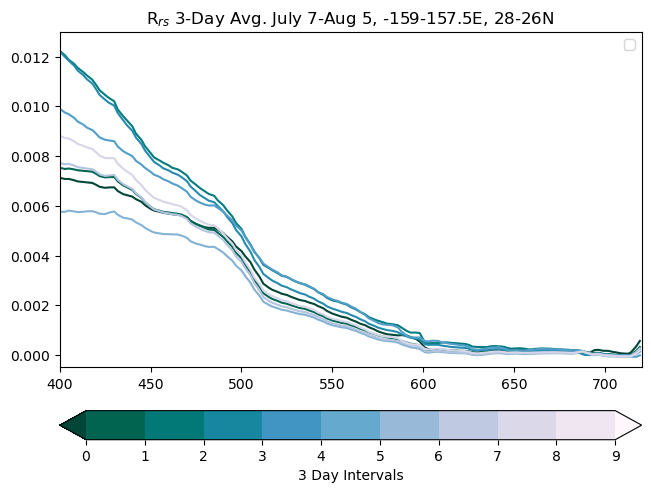

In [38]:
colors = pl.cm.PuBuGn.reversed()(np.linspace(0,1,10))
cmap = mpl.cm.PuBuGn.reversed()
bounds = [0,1,2,3,4,5,6,7,8,9]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig, ax = plt.subplots(layout='constrained')

for i in range(0,len(avgs)-1):
    plt.plot(region_corr["wavelength"].values,avgs[i], color=colors[i])
    plt.xlim([400,720])
    plt.ylim([-0.0005,0.013])
    plt.title(r'R$_{rs}$ 3-Day Avg. July 7-Aug 5, -159-157.5E, 28-26N')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='horizontal',
             label="3 Day Intervals")
#plt.plot(dfavg.Wavelength,dfavg.Average_Rrs,color='salmon',label='in-situ') #avgd from 16th to 20th
# plt.plot(region_corr["wavelength"].values,in_situ_averages, color='blue')

plt.legend()
plt.savefig("Rrs_Hawaii_avgd.png")

#16, 17 18 20 days from in situ


In [42]:
(np.ones([30,30,200]) - np.ones([200]))

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

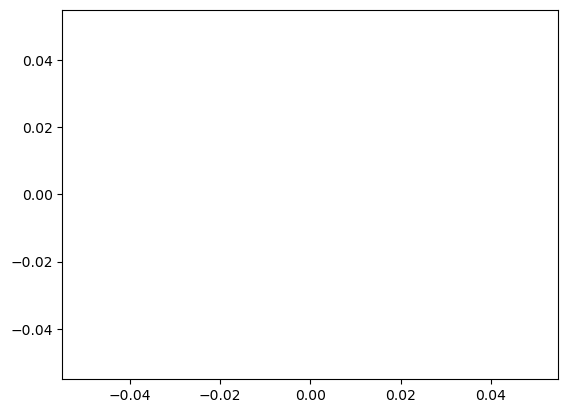

In [12]:
plt.plot(region["wavelength"].values,region["Rrs"].values[25], color='red", label='%s day' % i)
